# Super-res on Tiny Imagenet using tinyai

## Setup

In [ ]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *
from tinyai.sgd import *
from tinyai.resnet import *
from tinyai.augment import *
from tinyai.accel import *
from tinyai.training import *

In [ ]:
from fastprogress import progress_bar
from glob import glob

In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing
copied paste from notebook 24

In [ ]:
path = Path()/'data'/'tiny-imagenet-200'
bs = 512
# bs = 32
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [ ]:
tfms = nn.Sequential(T.Pad(8),
    T.RandomCrop(64),
    T.RandomHorizontalFlip())

In [ ]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = read_image(self.files[i], mode=ImageReadMode.RGB)/255
        return tfms((img-xmean[:,None,None])/xstd[:,None,None])

class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item),self.tfmy(item)

def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clamp(0,1)

We also not only just scale our pixel by factor of 2 bot also sometimes do a random erase\
We do that to force the network to learn the pattern in the images.

In [ ]:
def tfmx(x, erase=True):
    x = TF.resize(x, (32,32), antialias=True)[None]
    x = F.interpolate(x, scale_factor=2) # we scale the image up to 64x64 by increasing the pixel size by 2
    if erase: x = rand_erase(x)
    return x[0]

In [ ]:
tds = TinyDS(path/'train')
vds = TinyDS(path/'val')

tfm_tds = TfmDS(tds, tfmx)
tfm_vds = TfmDS(vds, partial(tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [ ]:
xb,yb = next(iter(dls.train))

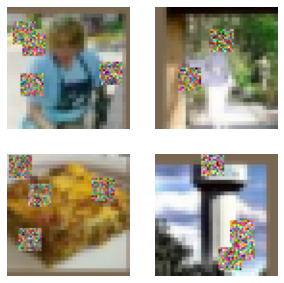

In [ ]:
show_images(denorm(xb[:4]), imsize=2.5)

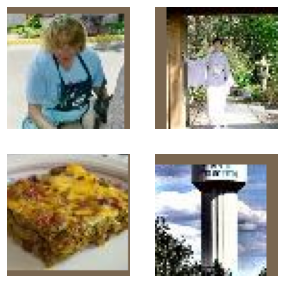

In [ ]:
show_images(denorm(yb[:4]), imsize=2.5)

## Denoising autoencoder

In [ ]:
def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [ ]:
def get_model(act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d, drop=0.1):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [up_block(nfs[i], nfs[i-1], act=act, norm=norm) for i in range(len(nfs)-1,0,-1)]
    layers += [ResBlock(nfs[0], 3, act=nn.Identity, norm=norm)]
    return nn.Sequential(*layers).apply(iw)

In [ ]:
iw = partial(init_weights, leaky=0.1)

In [ ]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]
lr_cbs = [DeviceCB(), ProgressCB(), MixedPrecision()]
opt_func = partial(optim.AdamW, eps=1e-5)

In [ ]:
learn = Learner(get_model().apply(iw), dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func)

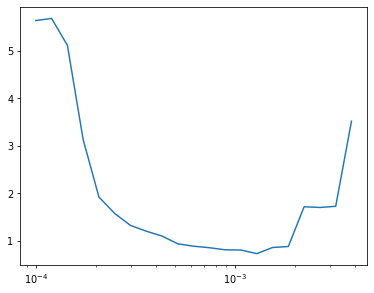

In [ ]:
learn.lr_find(start_lr=1e-4, gamma=1.2)

In [ ]:
epochs = 5
lr = 1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model().apply(iw), dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.582,0,train
0.358,0,eval
0.310,1,train
0.259,1,eval
0.248,2,train
0.228,2,eval
0.225,3,train
0.206,3,eval
0.217,4,train
0.203,4,eval


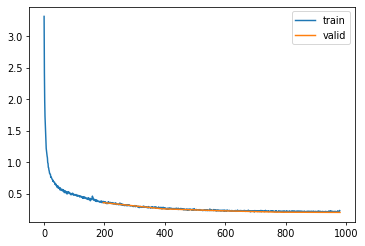

In [ ]:
learn.fit(epochs)

loss,epoch,train
0.203,0,eval


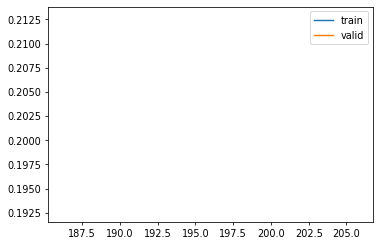

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

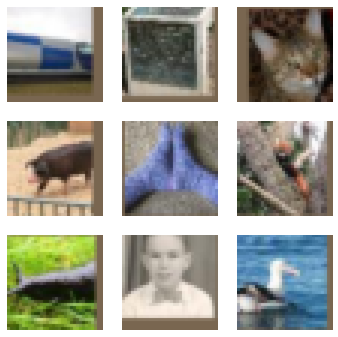

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

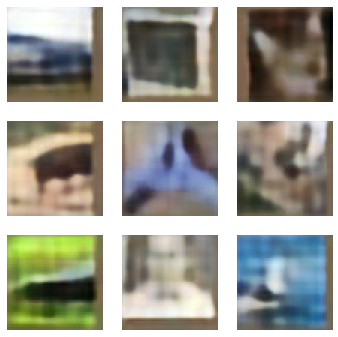

In [ ]:
show_images(denorm(p[:9]), imsize=2)

In [ ]:
del(learn)
clean_mem()

## Unet
paper - https://arxiv.org/pdf/1505.04597.pdf

In [ ]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = [] # for the skip connections
        layers.append(x)
        x = self.start(x)
        for l in self.dn: # downsampling
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up): # upsampling
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

In [ ]:
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [ ]:
model = TinyUnet()

In [ ]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

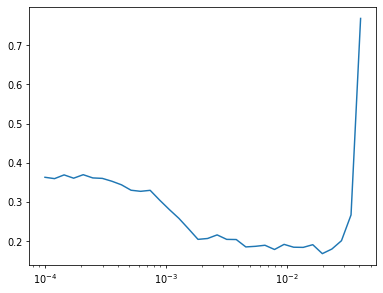

In [ ]:
learn = Learner(model, dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find(start_lr=1e-4, gamma=1.2)

In [ ]:
model = TinyUnet()

To ensure that the image we provide doesn't get lost during the first pass over the Unet, we zero the weights of the last layer. This serves as a baseline for the model to learn from.

In [ ]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

In [ ]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.160,0,train
0.081,0,eval
0.100,1,train
0.076,1,eval
0.090,2,train
0.073,2,eval
0.086,3,train
0.073,3,eval
0.084,4,train
0.070,4,eval


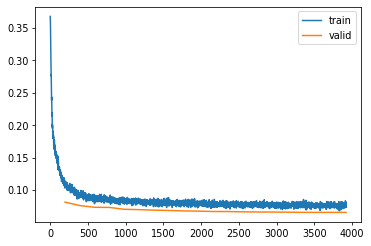

In [ ]:
learn.fit(epochs)

loss,epoch,train
0.065,0,eval


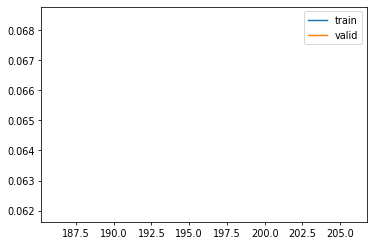

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

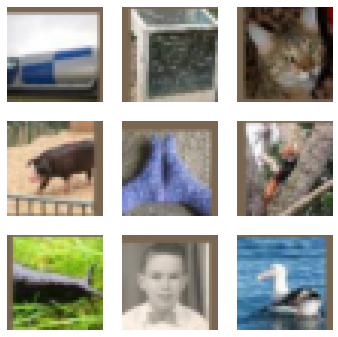

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

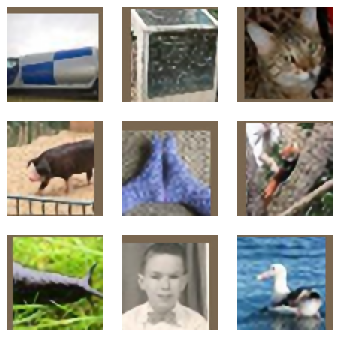

In [ ]:
show_images(denorm(p[:9]), imsize=2)

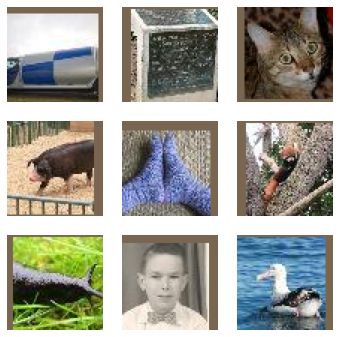

In [ ]:
show_images(denorm(t[:9]), imsize=2)

## Perceptual loss

In [ ]:
# del(learn)
# clean_mem()

In [ ]:
cmodel = torch.load('tinyai/nbs/models/inettiny-custom-25').cuda()

In [ ]:
xb,yb = next(iter(dls.valid))
with torch.autocast('cuda'),torch.no_grad(): preds = to_cpu(cmodel(yb.cuda().half()))
preds.shape

torch.Size([1024, 200])

In [ ]:
id2str = (path/'wnids.txt').read_text().splitlines()
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

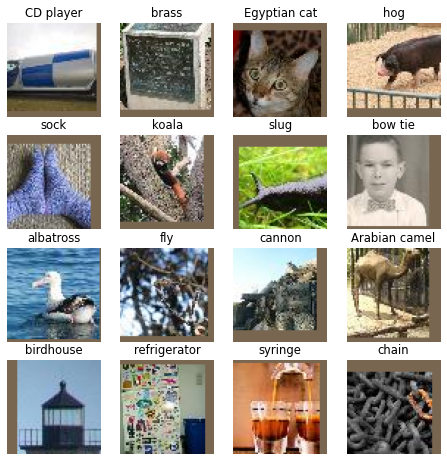

In [ ]:
titles = [synsets[id2str[o]] for o in preds.argmax(dim=1)]
show_images(denorm(yb[:16]), imsize=2, titles=titles[:16])

In [ ]:
for i in range(4,len(cmodel)): del(cmodel[4])

In [ ]:
with torch.autocast('cuda'),torch.no_grad():
    feat = to_cpu(cmodel(yb.cuda())).float()
    t = to_cpu(learn.model(yb.cuda())).float()
    pred_feat = to_cpu(cmodel(t.cuda())).float()

feat.shape

torch.Size([1024, 256, 8, 8])

### Combined Loss Function

The combined loss function is calculated as follows:

- Mean Squared Error (MSE) loss over the input and target images.
- MSE loss over the input features and target features, divided by 10 for numeric similarity.

This combined loss function helps optimize the model to improve both image quality and feature representation.


In [ ]:
def comb_loss(inp, tgt):
    with torch.autocast('cuda'):
        with torch.no_grad(): tgt_feat = cmodel(tgt).float()
        inp_feat = cmodel(inp).float()
    feat_loss = F.mse_loss(inp_feat, tgt_feat)
    return F.mse_loss(inp,tgt) + feat_loss/10

In [ ]:
def get_unet():
    model = TinyUnet()
    last_res = model.up[-1]
    zero_wgts(last_res.convs[-1][-1])
    zero_wgts(last_res.idconv[0])
    zero_wgts(model.end.convs[-1][-1])
    return model

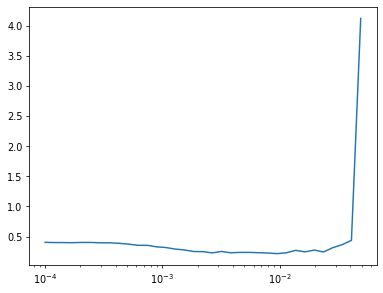

In [ ]:
Learner(get_unet(), dls, comb_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [ ]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_unet(), dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.194,0,train
0.107,0,eval
0.128,1,train
0.098,1,eval
0.115,2,train
0.095,2,eval
0.111,3,train
0.093,3,eval
0.108,4,train
0.091,4,eval


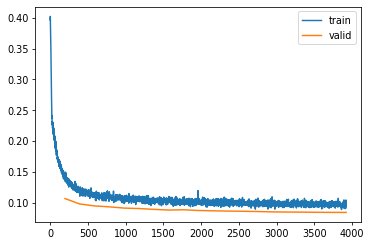

In [ ]:
learn.fit(epochs)

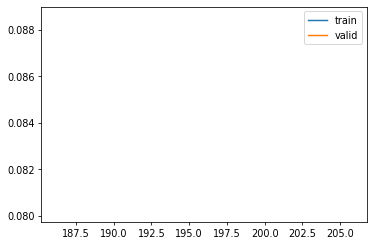

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

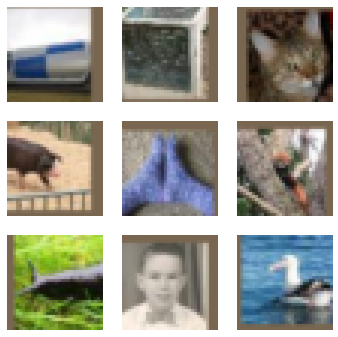

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

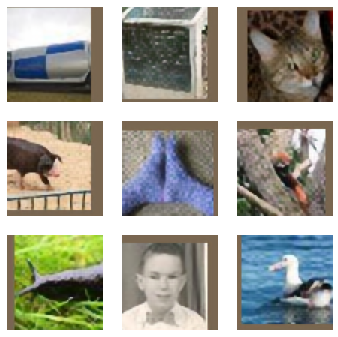

In [ ]:
show_images(denorm(p[:9]), imsize=2)

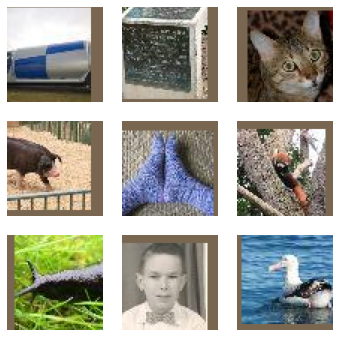

In [ ]:
show_images(denorm(t[:9]), imsize=2)

## FastAI Trick

Gradually unfreezing pretrained networks

In [ ]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

In [ ]:
model = get_unet()

We start by taking a pre-trained classifier model and loading its weights into the start and downsampling path of our super resolution model.

In [ ]:
pmodel = torch.load('tinyai/nbs/models/inettiny-custom-25')
model.start.load_state_dict(pmodel[0].state_dict())
for i in range(5): model.dn[i].load_state_dict(pmodel[i+1][0].state_dict()) # Had to add [0] to each state_dict

Freezing the loaded weights.

In [ ]:
for o in model.dn.parameters(): o.requires_grad_(False)

In [ ]:
epochs = 1
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.179,0,train
0.105,0,eval


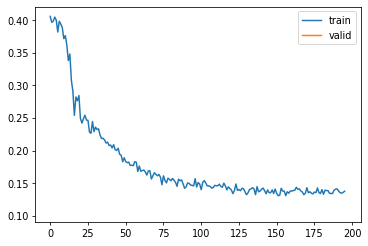

In [ ]:
learn.fit(epochs)

We have already beat the last model just by training for one epoch.

In [ ]:
for o in model.dn.parameters(): o.requires_grad_(True)

In [ ]:
epochs = 20
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

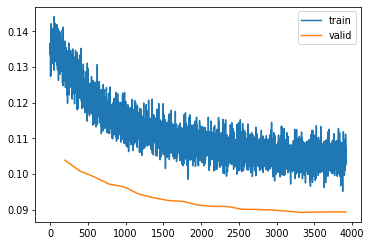

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'tinyai/nbs/models/superres-pcp.pkl')
# learn.model = torch.load('models/superres-pcp.pkl').cuda()

loss,epoch,train
0.089,0,eval


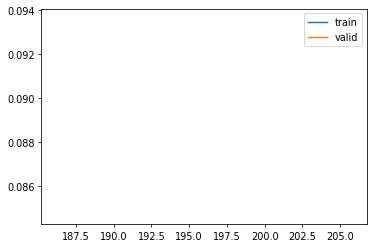

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

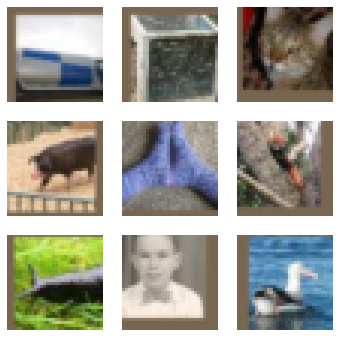

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

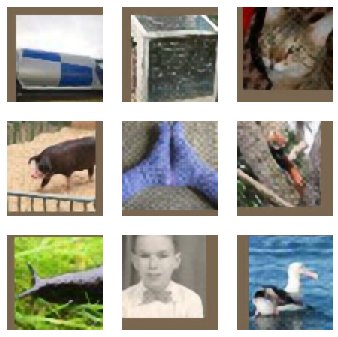

In [ ]:
show_images(denorm(p[:9]), imsize=2)

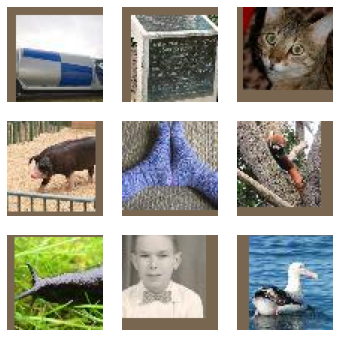

In [ ]:
show_images(denorm(t[:9]), imsize=2)

## Cross-convs

In [ ]:
def cross_conv(nf, act, norm):
    return nn.Sequential(
        ResBlock(nf, nf, act=act, norm=norm),
        nn.Conv2d(nf, nf, 3, padding=1)
    )

In [ ]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.xs = nn.ModuleList([cross_conv(nfs[i], act, norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.xs += [cross_conv(nfs[0], act, norm)]
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for i,l in enumerate(self.dn):
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += self.xs[i](layers[n-i])
            x = l(x)
        return self.end(x+layers[0])

In [ ]:
pmodel = torch.load('tinyai/nbs/models/inettiny-custom-25')

In [ ]:
model = get_unet()

In [ ]:
model.start.load_state_dict(pmodel[0].state_dict())
for i in range(5): model.dn[i].load_state_dict(pmodel[i+1][0].state_dict())
for o in model.dn.parameters(): o.requires_grad_(False)

In [ ]:
epochs = 1
lr = 3e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.168,0,train
0.101,0,eval


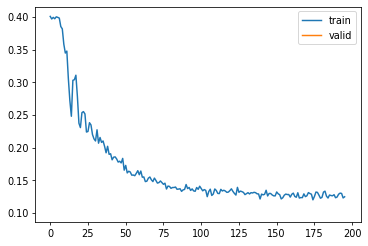

In [ ]:
learn.fit(epochs)

In [ ]:
for o in model.dn.parameters(): o.requires_grad_(True)

In [ ]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.124,0,train
0.098,0,eval
0.117,1,train
0.095,1,eval
0.113,2,train
0.093,2,eval
0.110,3,train
0.093,3,eval
0.109,4,train
0.091,4,eval


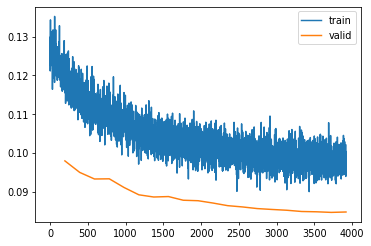

In [ ]:
learn.fit(epochs)

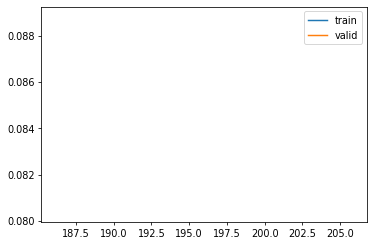

In [ ]:
p,t,inp = learn.capture_preds(inps=True)

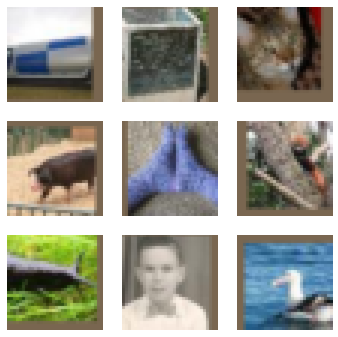

In [ ]:
show_images(denorm(inp[:9]), imsize=2)

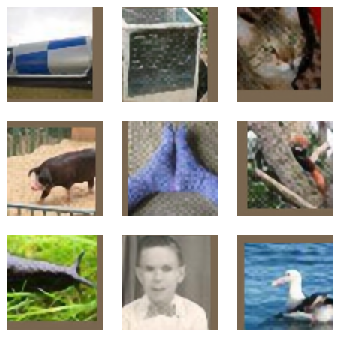

In [ ]:
show_images(denorm(p[:9]), imsize=2)

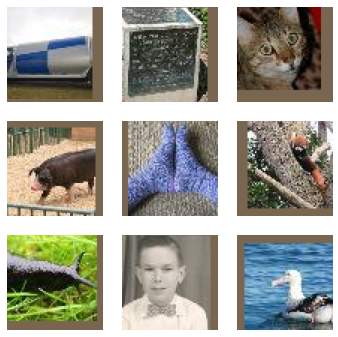

In [ ]:
show_images(denorm(t[:9]), imsize=2)

In [ ]:
torch.save(learn.model, 'tinyai/nbs/models/superres-cross.pkl')
# learn.model = torch.load('models/superres-pcp.pkl').cuda()